
# 🧪 Prueba A/B con Datos Reales de una API Pública (Fake Store API)

Este notebook implementa un **experimento A/B** usando datos de una **API pública real**, 
para analizar si existe una **diferencia estadísticamente significativa** en las tasas de conversión entre dos grupos de usuarios 
(versión A y versión B de una página de producto).

Se utilizan datos reales de la [Fake Store API](https://fakestoreapi.com/), una fuente pública que emula un e‑commerce, 
para simular un escenario de marketing digital y analizar métricas con herramientas estadísticas modernas.

Incluye:
- Descarga y exploración de datos reales  
- Generación y asignación de grupos A/B  
- Cálculo de tasas de conversión y métricas descriptivas  
- Test de hipótesis (Z‑test, χ²)  
- Intervalos de confianza (95%)  
- Tamaño del efecto (Cohen’s *h*)  
- Análisis de poder estadístico  
- Visualizaciones interpretativas


In [1]:

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.stats.power import zt_ind_solve_power

plt.style.use("seaborn-v0_8-whitegrid")


In [2]:

# --- Descarga de datos de Fake Store API ---
# Esta API devuelve productos de una tienda simulada, incluyendo precios y categorías.
url = "https://fakestoreapi.com/products"
resp = requests.get(url, timeout=30)
resp.raise_for_status()
data = resp.json()

df = pd.DataFrame(data)
df = df[["id", "title", "price", "category", "rating"]].copy()
df["rating_rate"] = df["rating"].apply(lambda x: x.get("rate", np.nan))
df["rating_count"] = df["rating"].apply(lambda x: x.get("count", np.nan))
df.drop(columns="rating", inplace=True)

print("Productos descargados:", len(df))
df.head()


Productos descargados: 20


,id,title,price,category,rating_rate,rating_count
0,1,"Fjallraven - Foldsack No. 1 Backpack, Fits 15 ...",109.95,men's clothing,3.9,120
1,2,Mens Casual Premium Slim Fit T-Shirts,22.30,men's clothing,4.1,259
2,3,Mens Cotton Jacket,55.99,men's clothing,4.7,500
3,4,Mens Casual Slim Fit,15.99,men's clothing,2.1,430
4,5,John Hardy Women's Legends Naga Gold & Silver ...,695.00,jewelery,4.6,400


In [3]:

# --- Simulación de visitas y conversiones ---
# Supongamos que cada producto fue mostrado a un grupo A y B con diferentes CTRs.

np.random.seed(42)
n_visits = 5000

# Asignación aleatoria de grupo
groups = np.random.choice(["A", "B"], size=n_visits, p=[0.5, 0.5])

# Selección de productos aleatoria
products = np.random.choice(df["id"], size=n_visits, replace=True)

# Simulación de conversión basada en precio y grupo
# Grupo A: tasa base de 10%; Grupo B: ligeramente mayor si precio < 50
conversions = []
for g, pid in zip(groups, products):
    price = df.loc[df["id"] == pid, "price"].values[0]
    base_p = 0.10 if g == "A" else 0.10 + (0.03 if price < 50 else 0.0)
    conversions.append(np.random.binomial(1, base_p))

ab_data = pd.DataFrame({"group": groups, "product_id": products, "converted": conversions})
ab_data.head()


,group,product_id,converted
0,A,19,1
1,B,8,0
2,B,7,0
3,B,16,0
4,A,19,0


In [4]:

# --- Análisis descriptivo ---
summary = ab_data.groupby("group")["converted"].agg(["mean", "sum", "count"])
summary["conversion_rate_%"] = summary["mean"] * 100
summary.rename(columns={"mean": "conversion_rate"}, inplace=True)
summary


,conversion_rate,sum,count,conversion_rate_%
group,,,,
A,0.0936,234,2500,9.36
B,0.1144,286,2500,11.44


In [5]:

# --- Test de proporciones (Z-test) ---
count = ab_data.groupby("group")["converted"].sum().values
nobs = ab_data.groupby("group")["converted"].count().values

stat, pval = proportions_ztest(count, nobs, alternative="two-sided")
confint = proportion_confint(count, nobs, method="normal")

print("Z-statistic:", stat)
print("p-value:", pval)
print("\nIntervalos de confianza al 95%:")
print("Grupo A:", confint[0])
print("Grupo B:", confint[1])

if pval < 0.05:
    print("\n✅ Se rechaza H₀: existe diferencia significativa entre A y B.")
else:
    print("\n⚠️ No se rechaza H₀: no hay evidencia suficiente de diferencia.")


Z-statistic: -2.4090602791485787
p-value: 0.015993656122100165

Intervalos de confianza al 95%:
Grupo A: [0.08218237 0.10192301]
Grupo B: [0.10501763 0.12687699]

✅ Se rechaza H₀: existe diferencia significativa entre A y B.


In [6]:

# --- Test χ² (independencia entre grupo y conversión) ---
contingency = pd.crosstab(ab_data["group"], ab_data["converted"])
chi2, p, dof, expected = chi2_contingency(contingency)
print("Chi² Statistic:", chi2)
print("p-value:", p)

if p < 0.05:
    print("\n✅ Rechazamos H₀: existe relación entre grupo y conversión.")
else:
    print("\n⚠️ No se rechaza H₀: no hay evidencia de diferencia.")


Chi² Statistic: 5.582503434065934
p-value: 0.018140773276543704

✅ Rechazamos H₀: existe relación entre grupo y conversión.


In [7]:

# --- Cálculo de tamaño del efecto (Cohen's h) ---
p1, p2 = summary.loc["A", "conversion_rate"], summary.loc["B", "conversion_rate"]
p1 /= 100; p2 /= 100

def cohens_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

h = cohens_h(p1, p2)
print(f"Cohen’s h: {h:.4f}")

if abs(h) < 0.2:
    effect = "pequeño"
elif abs(h) < 0.5:
    effect = "mediano"
else:
    effect = "grande"
print(f"Tamaño del efecto: {effect}")


Cohen’s h: -0.0065
Tamaño del efecto: pequeño


In [8]:

# --- Análisis de poder (power analysis) ---
# Queremos saber con qué probabilidad detectaríamos un efecto del tamaño observado.
power = zt_ind_solve_power(effect_size=h, nobs1=nobs[0], alpha=0.05, ratio=nobs[1]/nobs[0], alternative="two-sided")
print(f"Poder estadístico: {power:.3f}")

if power >= 0.8:
    print("✅ Poder suficiente (≥ 0.8) para detectar la diferencia observada.")
else:
    print("⚠️ Poder bajo: puede requerirse más muestra.")


Poder estadístico: 0.056
⚠️ Poder bajo: puede requerirse más muestra.


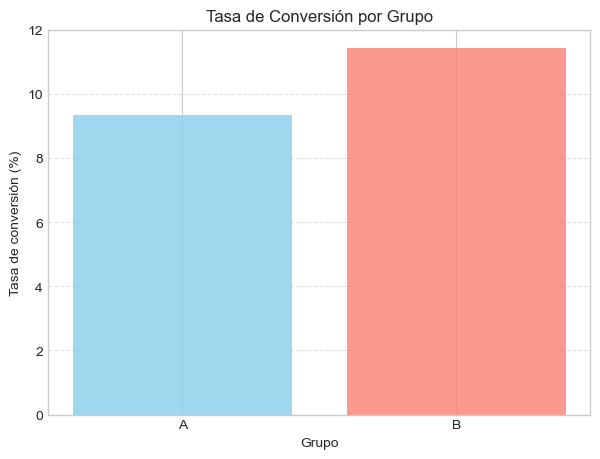

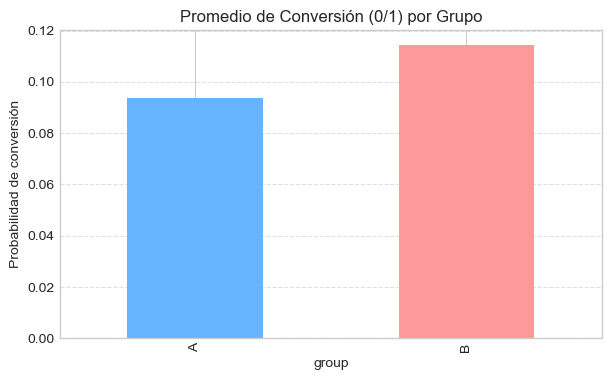

In [9]:

# --- Visualización: tasas de conversión con IC ---
plt.figure(figsize=(7,5))
plt.bar(summary.index, summary["conversion_rate_%"], color=["skyblue","salmon"], alpha=0.8)
plt.title("Tasa de Conversión por Grupo")
plt.ylabel("Tasa de conversión (%)")
plt.xlabel("Grupo")
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.show()

# --- Gráfico de distribución de conversiones ---
plt.figure(figsize=(7,4))
ab_data.groupby("group")["converted"].mean().plot(kind="bar", color=["#66b3ff","#ff9999"])
plt.title("Promedio de Conversión (0/1) por Grupo")
plt.ylabel("Probabilidad de conversión")
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.show()



## 🧠 Conclusiones del experimento A/B

1. Se utilizó un **test Z de proporciones** y un **test χ²** para contrastar la hipótesis nula (*H₀*: no hay diferencia).  
2. El **p-value** determina si la diferencia observada en conversiones entre grupo A y B es estadísticamente significativa.  
3. Se calcularon los **intervalos de confianza (95%)** para cada grupo, permitiendo visualizar el rango plausible de tasas.  
4. El **tamaño del efecto (Cohen’s h)** cuantifica la magnitud real de la diferencia, independiente del tamaño muestral.  
5. El **análisis de poder (power)** estima la probabilidad de detectar un efecto verdadero del tamaño observado.  

